# Model training.

[Dataset](https://github.com/imesluh/vocalfolds)


In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import modelIdentity
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 7
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-4
WEIGHT_DECAY = 1e-8
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob('../../vocalfolds/img/*/*/*.png')
MASK_DATASET_PATH  = glob('../../vocalfolds/annot/*/*/*.png')

N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 536


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[0],[1],[2],[3],[4],[5],[6]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (NUM_CLASSES, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelIdentity.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=NUM_CLASSES, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 428 examples in the training set...
[INFO] found 108 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.CombinedLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=WEIGHT_DECAY)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1

scheduler = CosineAnnealingLR(opt, T_max=trainSteps*NUM_EPOCHS)

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		scheduler.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/vf_uformeridentity.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 14/14 [00:07<00:00,  1.92it/s]


[INFO] EPOCH: 1/100
Train loss: 2.954003, Test loss: 2.9116, Train IoU: 0.1182, Test IoU: 0.1450, Train Dice: 0.2107, Test Dice: 0.2533
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


[INFO] EPOCH: 2/100
Train loss: 2.886386, Test loss: 2.8764, Train IoU: 0.1618, Test IoU: 0.1685, Train Dice: 0.2784, Test Dice: 0.2884
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


[INFO] EPOCH: 3/100
Train loss: 2.856068, Test loss: 2.8518, Train IoU: 0.1828, Test IoU: 0.1856, Train Dice: 0.3087, Test Dice: 0.3131
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 4/100
Train loss: 2.837892, Test loss: 2.8391, Train IoU: 0.1957, Test IoU: 0.1946, Train Dice: 0.3269, Test Dice: 0.3258
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


[INFO] EPOCH: 5/100
Train loss: 2.823750, Test loss: 2.8292, Train IoU: 0.2058, Test IoU: 0.2017, Train Dice: 0.3411, Test Dice: 0.3357
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[INFO] EPOCH: 6/100
Train loss: 2.812205, Test loss: 2.8273, Train IoU: 0.2146, Test IoU: 0.2031, Train Dice: 0.3526, Test Dice: 0.3376
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 7/100
Train loss: 2.812891, Test loss: 2.8236, Train IoU: 0.2140, Test IoU: 0.2058, Train Dice: 0.3519, Test Dice: 0.3412
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


[INFO] EPOCH: 8/100
Train loss: 2.806604, Test loss: 2.8221, Train IoU: 0.2185, Test IoU: 0.2069, Train Dice: 0.3582, Test Dice: 0.3427
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[INFO] EPOCH: 9/100
Train loss: 2.802790, Test loss: 2.8214, Train IoU: 0.2222, Test IoU: 0.2074, Train Dice: 0.3620, Test Dice: 0.3435
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 10/100
Train loss: 2.807959, Test loss: 2.8194, Train IoU: 0.2177, Test IoU: 0.2088, Train Dice: 0.3569, Test Dice: 0.3454
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 11/100
Train loss: 2.803063, Test loss: 2.8197, Train IoU: 0.2210, Test IoU: 0.2087, Train Dice: 0.3618, Test Dice: 0.3452


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 12/100
Train loss: 2.804149, Test loss: 2.8194, Train IoU: 0.2206, Test IoU: 0.2089, Train Dice: 0.3607, Test Dice: 0.3455
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 13/100
Train loss: 2.810427, Test loss: 2.8179, Train IoU: 0.2166, Test IoU: 0.2099, Train Dice: 0.3544, Test Dice: 0.3470
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 14/100
Train loss: 2.805080, Test loss: 2.8163, Train IoU: 0.2197, Test IoU: 0.2111, Train Dice: 0.3597, Test Dice: 0.3486
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 15/100
Train loss: 2.802060, Test loss: 2.8128, Train IoU: 0.2222, Test IoU: 0.2137, Train Dice: 0.3628, Test Dice: 0.3521
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 16/100
Train loss: 2.801317, Test loss: 2.8093, Train IoU: 0.2231, Test IoU: 0.2162, Train Dice: 0.3635, Test Dice: 0.3555
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 17/100
Train loss: 2.791680, Test loss: 2.8049, Train IoU: 0.2296, Test IoU: 0.2196, Train Dice: 0.3731, Test Dice: 0.3600
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 18/100
Train loss: 2.785676, Test loss: 2.8014, Train IoU: 0.2344, Test IoU: 0.2222, Train Dice: 0.3791, Test Dice: 0.3635
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 19/100
Train loss: 2.778453, Test loss: 2.7892, Train IoU: 0.2402, Test IoU: 0.2313, Train Dice: 0.3864, Test Dice: 0.3756
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 20/100
Train loss: 2.775221, Test loss: 2.7827, Train IoU: 0.2424, Test IoU: 0.2363, Train Dice: 0.3896, Test Dice: 0.3822
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 21/100
Train loss: 2.769190, Test loss: 2.7694, Train IoU: 0.2469, Test IoU: 0.2466, Train Dice: 0.3956, Test Dice: 0.3955
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 22/100
Train loss: 2.748273, Test loss: 2.7496, Train IoU: 0.2632, Test IoU: 0.2620, Train Dice: 0.4165, Test Dice: 0.4152
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 23/100
Train loss: 2.731498, Test loss: 2.7319, Train IoU: 0.2772, Test IoU: 0.2764, Train Dice: 0.4333, Test Dice: 0.4330
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 24/100
Train loss: 2.714062, Test loss: 2.7146, Train IoU: 0.2913, Test IoU: 0.2906, Train Dice: 0.4507, Test Dice: 0.4503
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 25/100
Train loss: 2.695841, Test loss: 2.6942, Train IoU: 0.3066, Test IoU: 0.3079, Train Dice: 0.4690, Test Dice: 0.4707
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 26/100
Train loss: 2.672724, Test loss: 2.6677, Train IoU: 0.3266, Test IoU: 0.3310, Train Dice: 0.4921, Test Dice: 0.4972
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 27/100
Train loss: 2.652219, Test loss: 2.6449, Train IoU: 0.3448, Test IoU: 0.3516, Train Dice: 0.5126, Test Dice: 0.5200
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 28/100
Train loss: 2.627761, Test loss: 2.6230, Train IoU: 0.3675, Test IoU: 0.3719, Train Dice: 0.5370, Test Dice: 0.5419
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 29/100
Train loss: 2.610716, Test loss: 2.6071, Train IoU: 0.3838, Test IoU: 0.3871, Train Dice: 0.5541, Test Dice: 0.5578
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 30/100
Train loss: 2.595312, Test loss: 2.5984, Train IoU: 0.3984, Test IoU: 0.3955, Train Dice: 0.5695, Test Dice: 0.5665
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 31/100
Train loss: 2.584171, Test loss: 2.5865, Train IoU: 0.4093, Test IoU: 0.4072, Train Dice: 0.5806, Test Dice: 0.5784
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 32/100
Train loss: 2.569009, Test loss: 2.5665, Train IoU: 0.4246, Test IoU: 0.4274, Train Dice: 0.5958, Test Dice: 0.5984
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 33/100
Train loss: 2.556264, Test loss: 2.5614, Train IoU: 0.4376, Test IoU: 0.4331, Train Dice: 0.6085, Test Dice: 0.6035
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 34/100
Train loss: 2.549330, Test loss: 2.5390, Train IoU: 0.4452, Test IoU: 0.4559, Train Dice: 0.6155, Test Dice: 0.6259
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 35/100
Train loss: 2.531002, Test loss: 2.5319, Train IoU: 0.4643, Test IoU: 0.4634, Train Dice: 0.6338, Test Dice: 0.6330
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 36/100
Train loss: 2.518229, Test loss: 2.5176, Train IoU: 0.4782, Test IoU: 0.4793, Train Dice: 0.6466, Test Dice: 0.6472
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 37/100
Train loss: 2.506654, Test loss: 2.5107, Train IoU: 0.4907, Test IoU: 0.4867, Train Dice: 0.6581, Test Dice: 0.6542
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 38/100
Train loss: 2.498930, Test loss: 2.5030, Train IoU: 0.4997, Test IoU: 0.4950, Train Dice: 0.6659, Test Dice: 0.6618
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 39/100
Train loss: 2.503305, Test loss: 2.5138, Train IoU: 0.4950, Test IoU: 0.4830, Train Dice: 0.6615, Test Dice: 0.6511


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 40/100
Train loss: 2.501090, Test loss: 2.4997, Train IoU: 0.4970, Test IoU: 0.4988, Train Dice: 0.6637, Test Dice: 0.6652
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 41/100
Train loss: 2.482887, Test loss: 2.5012, Train IoU: 0.5180, Test IoU: 0.4969, Train Dice: 0.6819, Test Dice: 0.6637


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 42/100
Train loss: 2.481109, Test loss: 2.4933, Train IoU: 0.5200, Test IoU: 0.5058, Train Dice: 0.6837, Test Dice: 0.6715
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 43/100
Train loss: 2.483560, Test loss: 2.4792, Train IoU: 0.5174, Test IoU: 0.5224, Train Dice: 0.6812, Test Dice: 0.6856
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 44/100
Train loss: 2.469224, Test loss: 2.4936, Train IoU: 0.5337, Test IoU: 0.5065, Train Dice: 0.6956, Test Dice: 0.6713


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 45/100
Train loss: 2.466361, Test loss: 2.4745, Train IoU: 0.5369, Test IoU: 0.5282, Train Dice: 0.6984, Test Dice: 0.6904
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 46/100
Train loss: 2.458265, Test loss: 2.4725, Train IoU: 0.5468, Test IoU: 0.5303, Train Dice: 0.7065, Test Dice: 0.6924
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 47/100
Train loss: 2.457740, Test loss: 2.4678, Train IoU: 0.5474, Test IoU: 0.5358, Train Dice: 0.7071, Test Dice: 0.6970
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 48/100
Train loss: 2.452678, Test loss: 2.4645, Train IoU: 0.5534, Test IoU: 0.5398, Train Dice: 0.7121, Test Dice: 0.7004
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 49/100
Train loss: 2.455629, Test loss: 2.4713, Train IoU: 0.5505, Test IoU: 0.5320, Train Dice: 0.7092, Test Dice: 0.6935


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 50/100
Train loss: 2.452055, Test loss: 2.4593, Train IoU: 0.5544, Test IoU: 0.5464, Train Dice: 0.7127, Test Dice: 0.7056
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 51/100
Train loss: 2.439787, Test loss: 2.4550, Train IoU: 0.5691, Test IoU: 0.5507, Train Dice: 0.7250, Test Dice: 0.7099
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 52/100
Train loss: 2.442664, Test loss: 2.4589, Train IoU: 0.5655, Test IoU: 0.5468, Train Dice: 0.7221, Test Dice: 0.7060


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 53/100
Train loss: 2.439380, Test loss: 2.4492, Train IoU: 0.5697, Test IoU: 0.5578, Train Dice: 0.7254, Test Dice: 0.7157
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 54/100
Train loss: 2.437353, Test loss: 2.4485, Train IoU: 0.5720, Test IoU: 0.5587, Train Dice: 0.7275, Test Dice: 0.7163
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 55/100
Train loss: 2.435242, Test loss: 2.4456, Train IoU: 0.5747, Test IoU: 0.5625, Train Dice: 0.7296, Test Dice: 0.7193
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 56/100
Train loss: 2.434393, Test loss: 2.4445, Train IoU: 0.5758, Test IoU: 0.5638, Train Dice: 0.7304, Test Dice: 0.7204
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 57/100
Train loss: 2.423717, Test loss: 2.4424, Train IoU: 0.5890, Test IoU: 0.5665, Train Dice: 0.7411, Test Dice: 0.7225
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 58/100
Train loss: 2.422159, Test loss: 2.4477, Train IoU: 0.5912, Test IoU: 0.5602, Train Dice: 0.7426, Test Dice: 0.7171


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 59/100
Train loss: 2.420113, Test loss: 2.4406, Train IoU: 0.5936, Test IoU: 0.5685, Train Dice: 0.7447, Test Dice: 0.7242
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 60/100
Train loss: 2.423185, Test loss: 2.4369, Train IoU: 0.5899, Test IoU: 0.5729, Train Dice: 0.7416, Test Dice: 0.7280
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 61/100
Train loss: 2.417752, Test loss: 2.4348, Train IoU: 0.5967, Test IoU: 0.5756, Train Dice: 0.7470, Test Dice: 0.7301
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 62/100
Train loss: 2.412421, Test loss: 2.4342, Train IoU: 0.6036, Test IoU: 0.5764, Train Dice: 0.7524, Test Dice: 0.7307
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 63/100
Train loss: 2.411571, Test loss: 2.4324, Train IoU: 0.6048, Test IoU: 0.5785, Train Dice: 0.7532, Test Dice: 0.7325
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 64/100
Train loss: 2.409865, Test loss: 2.4295, Train IoU: 0.6072, Test IoU: 0.5823, Train Dice: 0.7549, Test Dice: 0.7354
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 65/100
Train loss: 2.409062, Test loss: 2.4303, Train IoU: 0.6077, Test IoU: 0.5810, Train Dice: 0.7557, Test Dice: 0.7346


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 66/100
Train loss: 2.408453, Test loss: 2.4326, Train IoU: 0.6086, Test IoU: 0.5787, Train Dice: 0.7563, Test Dice: 0.7323


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 67/100
Train loss: 2.410178, Test loss: 2.4299, Train IoU: 0.6064, Test IoU: 0.5820, Train Dice: 0.7546, Test Dice: 0.7350


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 68/100
Train loss: 2.410395, Test loss: 2.4265, Train IoU: 0.6059, Test IoU: 0.5861, Train Dice: 0.7544, Test Dice: 0.7383
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 69/100
Train loss: 2.404328, Test loss: 2.4258, Train IoU: 0.6141, Test IoU: 0.5867, Train Dice: 0.7605, Test Dice: 0.7391
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 70/100
Train loss: 2.397743, Test loss: 2.4239, Train IoU: 0.6227, Test IoU: 0.5892, Train Dice: 0.7670, Test Dice: 0.7409
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 71/100
Train loss: 2.402484, Test loss: 2.4237, Train IoU: 0.6166, Test IoU: 0.5894, Train Dice: 0.7623, Test Dice: 0.7412
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 72/100
Train loss: 2.399796, Test loss: 2.4239, Train IoU: 0.6200, Test IoU: 0.5893, Train Dice: 0.7650, Test Dice: 0.7410


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 73/100
Train loss: 2.395330, Test loss: 2.4218, Train IoU: 0.6256, Test IoU: 0.5921, Train Dice: 0.7695, Test Dice: 0.7431
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 74/100
Train loss: 2.395384, Test loss: 2.4215, Train IoU: 0.6256, Test IoU: 0.5923, Train Dice: 0.7694, Test Dice: 0.7434
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 75/100
Train loss: 2.395314, Test loss: 2.4213, Train IoU: 0.6257, Test IoU: 0.5927, Train Dice: 0.7695, Test Dice: 0.7436
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 76/100
Train loss: 2.392305, Test loss: 2.4195, Train IoU: 0.6297, Test IoU: 0.5947, Train Dice: 0.7725, Test Dice: 0.7454
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 77/100
Train loss: 2.394396, Test loss: 2.4180, Train IoU: 0.6270, Test IoU: 0.5967, Train Dice: 0.7704, Test Dice: 0.7469
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 78/100
Train loss: 2.393032, Test loss: 2.4198, Train IoU: 0.6288, Test IoU: 0.5946, Train Dice: 0.7718, Test Dice: 0.7450


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 79/100
Train loss: 2.392550, Test loss: 2.4212, Train IoU: 0.6293, Test IoU: 0.5930, Train Dice: 0.7722, Test Dice: 0.7437


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 80/100
Train loss: 2.391186, Test loss: 2.4180, Train IoU: 0.6313, Test IoU: 0.5969, Train Dice: 0.7736, Test Dice: 0.7469
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 81/100
Train loss: 2.389766, Test loss: 2.4174, Train IoU: 0.6332, Test IoU: 0.5974, Train Dice: 0.7750, Test Dice: 0.7474
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 82/100
Train loss: 2.390754, Test loss: 2.4159, Train IoU: 0.6318, Test IoU: 0.5995, Train Dice: 0.7740, Test Dice: 0.7490
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 83/100
Train loss: 2.388155, Test loss: 2.4165, Train IoU: 0.6351, Test IoU: 0.5986, Train Dice: 0.7766, Test Dice: 0.7484


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 84/100
Train loss: 2.389664, Test loss: 2.4163, Train IoU: 0.6331, Test IoU: 0.5989, Train Dice: 0.7751, Test Dice: 0.7485


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 85/100
Train loss: 2.388646, Test loss: 2.4185, Train IoU: 0.6346, Test IoU: 0.5964, Train Dice: 0.7761, Test Dice: 0.7464


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 86/100
Train loss: 2.388237, Test loss: 2.4155, Train IoU: 0.6350, Test IoU: 0.6000, Train Dice: 0.7766, Test Dice: 0.7494
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 87/100
Train loss: 2.386000, Test loss: 2.4154, Train IoU: 0.6381, Test IoU: 0.6002, Train Dice: 0.7788, Test Dice: 0.7495
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 88/100
Train loss: 2.388546, Test loss: 2.4155, Train IoU: 0.6346, Test IoU: 0.6001, Train Dice: 0.7763, Test Dice: 0.7494


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 89/100
Train loss: 2.385602, Test loss: 2.4158, Train IoU: 0.6386, Test IoU: 0.5997, Train Dice: 0.7792, Test Dice: 0.7491


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 90/100
Train loss: 2.388463, Test loss: 2.4151, Train IoU: 0.6348, Test IoU: 0.6005, Train Dice: 0.7763, Test Dice: 0.7497
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 91/100
Train loss: 2.386108, Test loss: 2.4149, Train IoU: 0.6379, Test IoU: 0.6007, Train Dice: 0.7787, Test Dice: 0.7499
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 92/100
Train loss: 2.386346, Test loss: 2.4148, Train IoU: 0.6377, Test IoU: 0.6009, Train Dice: 0.7784, Test Dice: 0.7501
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 93/100
Train loss: 2.385812, Test loss: 2.4149, Train IoU: 0.6383, Test IoU: 0.6007, Train Dice: 0.7790, Test Dice: 0.7499


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 94/100
Train loss: 2.386377, Test loss: 2.4153, Train IoU: 0.6379, Test IoU: 0.6003, Train Dice: 0.7784, Test Dice: 0.7495


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 95/100
Train loss: 2.385406, Test loss: 2.4154, Train IoU: 0.6390, Test IoU: 0.6002, Train Dice: 0.7794, Test Dice: 0.7494


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 96/100
Train loss: 2.385739, Test loss: 2.4149, Train IoU: 0.6386, Test IoU: 0.6008, Train Dice: 0.7791, Test Dice: 0.7499


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 97/100
Train loss: 2.385317, Test loss: 2.4149, Train IoU: 0.6389, Test IoU: 0.6008, Train Dice: 0.7795, Test Dice: 0.7500


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 98/100
Train loss: 2.384553, Test loss: 2.4149, Train IoU: 0.6401, Test IoU: 0.6009, Train Dice: 0.7802, Test Dice: 0.7500


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 99/100
Train loss: 2.385171, Test loss: 2.4149, Train IoU: 0.6392, Test IoU: 0.6008, Train Dice: 0.7796, Test Dice: 0.7499


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 100/100
Train loss: 2.386045, Test loss: 2.4149, Train IoU: 0.6382, Test IoU: 0.6008, Train Dice: 0.7787, Test Dice: 0.7499
[INFO] total time taken to train the model: 593.01s
Best IoU is: 0.60090


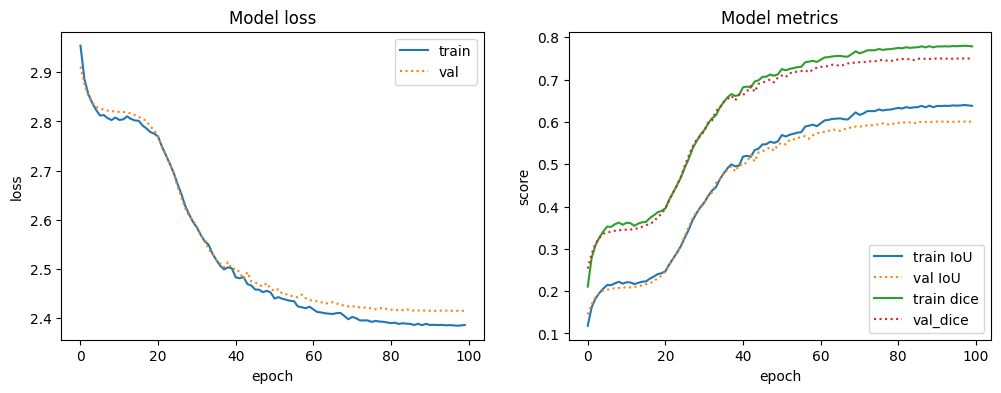

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

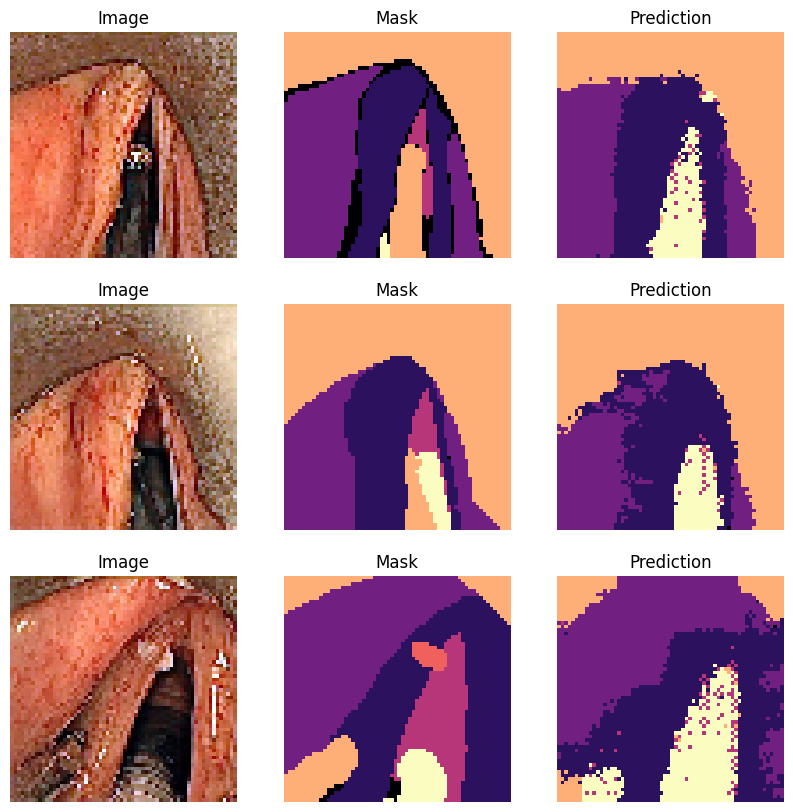

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota